# 1-sample test for detecting clusters for featured spectrograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import os
import mne
from mne.time_frequency import tfr_morlet
import pandas as pd
import scipy.io as io
from numpy import loadtxt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import sklearn.metrics.pairwise as pairwise
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [89]:
import sys
sys.path+=['/data/dian/Dropbox/Stanford_Matters/data/THAL/UMAP',
           '/data/dian/Dropbox/scripts/Stanford/ThalamocoricalLoop-project/utils']
import customFunctions
import statsFunctions
import importlib
importlib.reload(customFunctions)
importlib.reload(statsFunctions)
from customFunctions import *
from statsFunctions import *

In [3]:
os.chdir('/data/dian/Dropbox/Stanford_Matters/data/THAL/CCEP/results/explore5_locked')

In [4]:
metaT = pd.read_csv('table_CCEPnewpipOutput_wholebrain_anatomical_info_activationRedone2.csv')
metaT.head()

,subject,aSubID,block_name,stim_chan,record_chan,sc1,sc2,rc1,rc2,stim_shank,...,pks_time_3,pks_time_4,pks_time_5,pks_time_6,pks_time_7,pks_time_8,pks_time_9,pks_time_10,pks_time_11,pks_time_12
0,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF1-LORF2,LPCN1,LPCN2,LORF1,LORF2,0,...,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF2-LORF3,LPCN1,LPCN2,LORF2,LORF3,0,...,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF3-LORF4,LPCN1,LPCN2,LORF3,LORF4,0,...,73.0,167.0,476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF4-LORF5,LPCN1,LPCN2,LORF4,LORF5,0,...,157.0,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF5-LORF6,LPCN1,LPCN2,LORF5,LORF6,0,...,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## load data

In [168]:
dat = np.load('UMAP/ALLDATA_semisupervise/input_dat1_untransformed.npy')
# save as a mat file
#dat_dic = {'dat': dat}
#io.savemat( 'UMAP/ALLDATA_semisupervise/input_dat1_untransformed.mat',dat_dic)

In [6]:
dat.shape

(58598, 2580)

In [15]:
sblist = metaT.subject.unique()
sblist = np.delete(sblist, np.where(sblist=='S23_196_HL'))
print(sblist.shape)
print(sblist)
mat = mergeMat([sblist[0]], keys=['filteridx_metaT','Vrpw','Vrpc', 'Vrph'],
              inputDir = 'UMAP_learn/resample3')
n1=mat['Vrpw'].shape[1]
n2=mat['Vrpc'].shape[1]

(26,)
['S21_166_TM' 'S21_167_MQ' 'S21_169_BH' 'S21_170_JL' 'S21_171_MM'
 'S21_172_KS' 'S22_176_LB' 'S22_177_JM' 'S22_178_AF' 'S22_181_CB'
 'S22_182_DH' 'S22_183_CR' 'S22_185_TW' 'S22_188_CB' 'S22_189_LMA'
 'S22_190_AS' 'S22_192_LG' 'S22_193_AM' 'S23_194_PS' 'S23_195_MZ'
 'S23_197_TA' 'S23_198_JP' 'S23_199_GB' 'S23_201_JG' 'S23_202_KC'
 'S23_205_LLC']


In [18]:
# import results from UMAP supervised training using anatomical information
brainInfo = pd.read_csv('UMAP/ALLDATA_semisupervise/brainInfo.csv')
brainInfo.shape

(58598, 73)

In [19]:
isnoise = loadtxt('UMAP/ALLDATA_semisupervise/isnoise.txt',
                delimiter="\t")
cleanFeatures = loadtxt('UMAP/ALLDATA_semisupervise/cleanFeatures.txt',
                delimiter="\t",dtype='str')
len(cleanFeatures)

58598

In [103]:
ftypes = list(set(cleanFeatures))
print(ftypes)

['COR-ipsi', 'THAL-contr', 'THAL-ipsi', 'COR-contr']


### Within-subject cluster permutation test for each category

In [216]:
it1 = 1

print('Group1: %s'%(ftypes[it1]))
filterBoolean = (cleanFeatures==ftypes[it1])&( isnoise==0) 
brain_info1 = brainInfo[filterBoolean]
print(brain_info1.shape)
d1_ = dat[filterBoolean]
print(d1_.shape)
# impute missing data
# Preprocess - simulate nan values, which are few
pipe = make_pipeline(SimpleImputer(strategy="mean"))
d1 = pipe.fit_transform(d1_.copy())

Group1: THAL-contr
(619, 73)
(619, 2580)


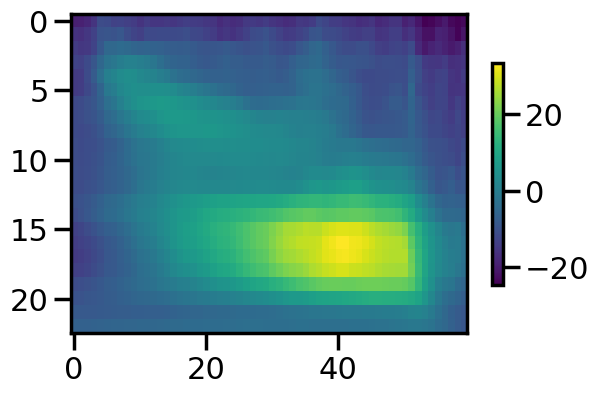

In [217]:
ntime=60
tG1 = tscore_1sample(d1)
plt.close()
plt.figure()
sp1=plt.imshow(np.rot90(tG1[0:n1].reshape(ntime, -1)),
          aspect=2.1)
plt.colorbar(sp1,shrink=0.6)

In [218]:
withinsb_Tscores = []

for i,sb in enumerate(sblist):
    idx1 = np.where(brain_info1.subject==sb)[0]
    if idx1.shape[0]==0:
        print(sb+' does not have group1 data...')
        continue
        
    sbd1 = d1[idx1,:]
    sbt = tscore_1sample(sbd1)
    #sbt = tscore_1sample(sbd1)-tscore_1sample(sbd2)
    withinsb_Tscores.append(sbt) # within-subject comparison of t-scores of each categories
    
withinsb_Tscores = np.array(withinsb_Tscores)
withinsb_Tscores.shape

S21_166_TM does not have group1 data...
S21_167_MQ does not have group1 data...
S21_170_JL does not have group1 data...
S22_176_LB does not have group1 data...
S22_190_AS does not have group1 data...
S22_192_LG does not have group1 data...


(20, 2580)

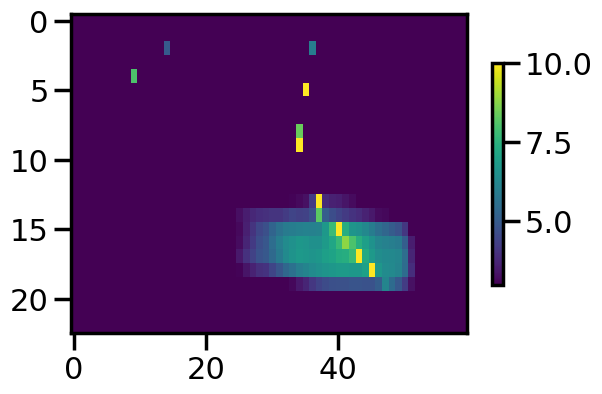

In [222]:
plt.close()
plt.figure()
dat2show = rotate(np.mean(withinsb_Tscores[:,0:n1],axis=0).reshape(ntime, -1))
p = plt.imshow(dat2show, aspect=2.1, vmin=3, vmax=10)
plt.colorbar(p,shrink=0.6)

Initial cluster threshold is 10
Degrees of freedom is 618
stat_fun(H1): min=-24.618568 max=33.380870
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

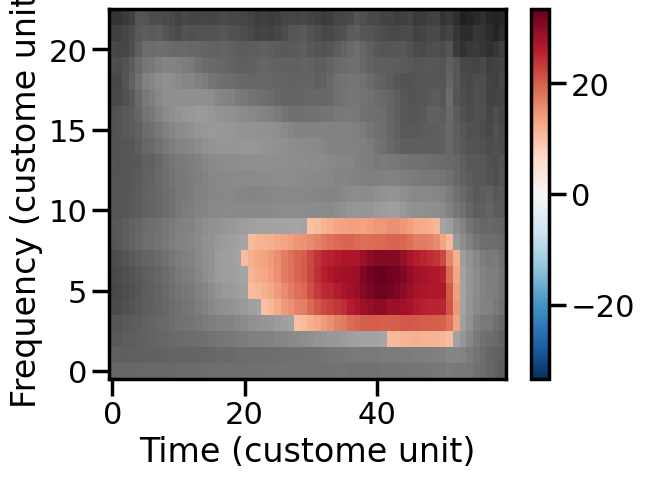

{'T_obs': array([[ -6.6573664 ,  -8.30801378, -10.01576852, ..., -14.30142511,
         -16.22147556, -19.45977379],
        [ -6.63721127,  -8.35789873,  -9.67747121, ..., -15.283322  ,
         -16.51620844, -19.33183782],
        [ -6.54930703,  -8.38259591,  -9.16427754, ..., -14.89456896,
         -15.22197397, -18.19069723],
        ...,
        [ -6.57284706,  -6.90375547,  -4.74856034, ..., -20.36762252,
         -21.62318003, -23.43327692],
        [ -7.86171594,  -7.8821335 ,  -5.84906722, ..., -19.23023402,
         -23.95951937, -24.21245008],
        [ -9.15191729,  -8.84311148,  -7.35330214, ..., -16.84234553,
         -21.34063054, -23.44067716]]),
 'clusters': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [Fa

In [227]:
# run test
pw1 = d1[:,0:n1].reshape(d1.shape[0], ntime,-1)
MNE1SampleSpectraSigTest(pw1, ifsave=1, threshold=10,
                         outname='Contrasted-nonactivated/mnePermutationCluster1Sample-Ttest_sigClsts_grouplogpower_%s.mat'%(ftypes[it1]))